## CS 476 A2
### Q3
#### Jeongseop Yi (Patrick), j22yi

In [21]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

#### Q3a)

In [22]:
# define functions for down-and-out call
def D1(S, K, r, sigma, T, t):
    return ((np.log(S/K) + (r + sigma**2/2)*(T-t)) 
            / (sigma*np.sqrt(T-t)))

def D2(S, K, r, sigma, T, t):
    return D1(S, K, r, sigma, T, t) - sigma*np.sqrt(T-t)

def D7(S, K, B, r, sigma, T, t):
    return ((np.log(S*K/(B**2)) - (r - sigma**2/2)*(T-t))
            / (sigma*np.sqrt(T-t)))

def D8(S, K, B, r, sigma, T, t):
    return D7(S, K, B, r, sigma, T, t) - sigma*np.sqrt(T-t)

def down_and_out_call_payout(S, K, B, r, sigma, T, t):
    d1 = D1(S, K, r, sigma, T, t)
    d2 = D2(S, K, r, sigma, T, t)
    d7 = D7(S, K, B, r, sigma, T, t)
    d8 = D8(S, K, B, r, sigma, T, t)

    return (S *
            (stats.norm.cdf(d1) - ((B/S)**(1 + 2 * r / (sigma ** 2)))
             * (1 - stats.norm.cdf(d8))) -
            K * np.exp(-r*(T-t)) *
            (stats.norm.cdf(d2) - ((B/S)**(-1 + 2 * r / (sigma ** 2)))
             * (1-stats.norm.cdf(d7))))


,Down-and-out call
S,
90.0,3.327341
92.0,4.614883
94.0,5.908461
96.0,7.222283
98.0,8.566792
100.0,9.949270
102.0,11.374382
104.0,12.844672
106.0,14.361002


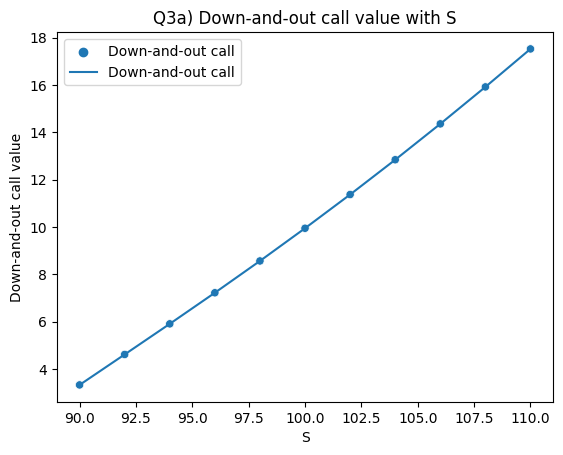

In [23]:
# define constants
S0 = 100
K = 100
B = 85
r = 0.05
sigma = 0.2
T = 1

# define range of S
S = np.arange(S0 * 0.9, S0 * 1.1, 2)

# calculate the down-and-out call for each S
ret = down_and_out_call_payout(S, K, B, r, sigma, T, 0)
ret = pd.DataFrame(ret, columns=['Down-and-out call'], index=S)
ret.index.name = 'S'
display(ret)

# plot the DataFrame
sns.scatterplot(data=ret)
sns.lineplot(data=ret)
plt.ylabel('Down-and-out call value')
plt.xlabel('S')
plt.title('Q3a) Down-and-out call value with S')
plt.show()


#### Q3b)

In [24]:
# define functions for cut-off
def down_and_out_cutoff(S, B):
    return np.where(S < B, 0, S)

# define functions for payoff
def down_and_out_payoff(S, K):
    # as the cut-off function takes care of the S_t <= B part, 
    # we only need to check S_T > K
    return np.where(S < K, 0, S - K)

# define functions for Monte Carlo simulation
def MC_simulation(S0, B, r, sigma, T, M, Dt, cut_off_func):
    S = np.zeros((M, int(T/Dt)))
    S[:, 0] = S0
    for i in range(1, int(T/Dt)):
        S[:, i] = S[:, i-1] * np.exp((r - sigma**2/2)*Dt +
                                     sigma*np.sqrt(Dt)*np.random.normal(0, 1, M))
        S[:, i] = cut_off_func(S[:, i], B)
    return S

# define function for Monte Carlo pricing
def MC_pricing(S0, K, B, r, sigma, T, M, Dt, cut_off_func, payoff_func):
    S = MC_simulation(S0, B, r, sigma, T, M, Dt, cut_off_func)
    return np.exp(-r*T) * np.mean(payoff_func(S[:, -1], K))


In [28]:
# constants for Monte Carlo simulation
M = np.arange(1000, 45001, 4000)
Dt = [0.01, 0.005, 0.0025, 0.001]

# calculate Monte Carlo pricing using DataFrame
df = pd.DataFrame(index=M, columns=Dt)
for m in M:
    for dt in Dt:
        df.loc[m, dt] = MC_pricing(S0, K, B, r, sigma, T, m, dt,
                                   down_and_out_cutoff, down_and_out_payoff)

df['VALUE'] = down_and_out_call_payout(S0, K, B, r, sigma, T, 0)


,0.01,0.005,0.0025,0.001,VALUE
1000,10.108465,9.606402,9.220892,10.170615,9.94927
5000,10.484565,9.881761,9.804328,9.813585,9.94927
9000,10.336334,10.142847,9.953405,9.931341,9.94927
13000,10.24145,10.076655,9.940652,10.108234,9.94927
17000,9.895963,9.942018,9.94733,10.121978,9.94927
21000,9.943135,10.088282,9.938178,9.837222,9.94927
25000,9.967693,9.948404,10.103164,10.005,9.94927
29000,9.974423,10.04849,10.021375,9.981032,9.94927
33000,10.038559,10.272524,10.118283,10.001381,9.94927
37000,10.031998,10.069738,10.158992,10.042217,9.94927


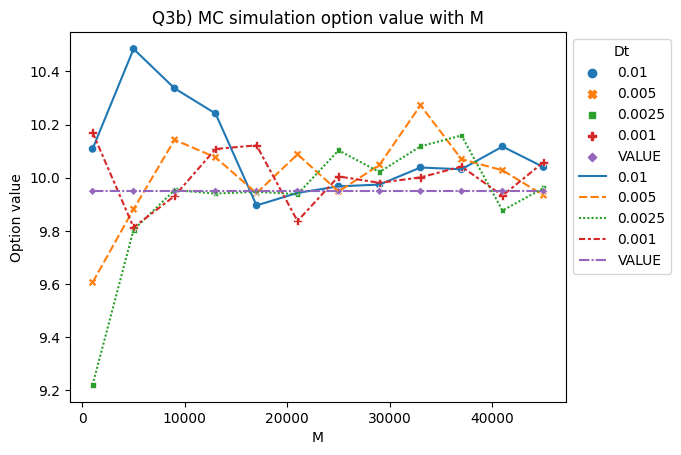

In [29]:
display(df)
a = sns.scatterplot(data=df)
b = sns.lineplot(data=df)
plt.legend(title="Dt")
sns.move_legend(a, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(b, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("M")
plt.ylabel("Option value")
plt.title("Q3b) MC simulation option value with M")
plt.show()


The error in the computed value $\tilde{V} (S(0), 0)$ depends on the time discretization. In theory, $\Delta t$ can be a infinitely small value close to 0 using limit. However, in computers, the smallest number possible for $\Delta t$ is always quantized to a value greater than 0. Therefore, there always exist a gap between $t_n$ and $t_{n+1} = t_n + \Delta t$ in computation creating discrepency between the theoretical formula and computed value $\tilde{V} (S(0), 0)$. The discrepency creates the uncertainty (error) to the computation. Therefore, there exists time discretization error for $\tilde{V} (S(0), 0)$.

As we are using randomized parameters, the result in the graph is different for each run. Still, as $M$ increases, the graphs have a tendency to converge to the exact option price computed in a), which is 9.949270. However, $\Delta t$ does not seem to play a big role on the convergence of the option value compared to $M$ using the above graph.